# PTN Template
This notebook serves as a template for single dataset PTN experiments  
It can be run on its own by setting STANDALONE to True (do a find for "STANDALONE" to see where)  
But it is intended to be executed as part of a *papermill.py script. See any of the   
experimentes with a papermill script to get started with that workflow.  

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Required Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "labels_source",
    "labels_target",
    "domains_source",
    "domains_target",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "n_shot",
    "n_way",
    "n_query",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_transforms_source",
    "x_transforms_target",
    "episode_transforms_source",
    "episode_transforms_target",
    "pickle_name",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "torch_default_dtype"
}

In [3]:


standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337


standalone_parameters["num_examples_per_domain_per_label_source"]=100
standalone_parameters["num_examples_per_domain_per_label_target"]=100

standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 100

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "target_accuracy"

standalone_parameters["x_transforms_source"] = ["unit_power"]
standalone_parameters["x_transforms_target"] = ["unit_power"]
standalone_parameters["episode_transforms_source"] = []
standalone_parameters["episode_transforms_target"] = []

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

# uncomment for CORES dataset
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)


standalone_parameters["labels_source"] = ALL_NODES
standalone_parameters["labels_target"] = ALL_NODES

standalone_parameters["domains_source"] = [1]
standalone_parameters["domains_target"] = [2,3,4,5]

standalone_parameters["pickle_name"] = "cores.stratified_ds.2022A.pkl"


# Uncomment these for ORACLE dataset
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )
# standalone_parameters["labels_source"] = ALL_SERIAL_NUMBERS
# standalone_parameters["labels_target"] = ALL_SERIAL_NUMBERS
# standalone_parameters["domains_source"] = [8,20, 38,50]
# standalone_parameters["domains_target"] = [14, 26, 32, 44, 56]
# standalone_parameters["pickle_name"] = "oracle.frame_indexed.stratified_ds.2022A.pkl"
# standalone_parameters["num_examples_per_domain_per_label_source"]=1000
# standalone_parameters["num_examples_per_domain_per_label_target"]=1000

# Uncomment these for Metahan dataset
# standalone_parameters["labels_source"] = list(range(19))
# standalone_parameters["labels_target"] = list(range(19))
# standalone_parameters["domains_source"] = [0]
# standalone_parameters["domains_target"] = [1]
# standalone_parameters["pickle_name"] = "metehan.stratified_ds.2022A.pkl"
# standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])
# standalone_parameters["num_examples_per_domain_per_label_source"]=200
# standalone_parameters["num_examples_per_domain_per_label_target"]=100


standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])

In [4]:
# Parameters
parameters = {
    "experiment_name": "tuned_1v2:wisig",
    "device": "cuda",
    "lr": 0.0001,
    "labels_source": [
        "1-10",
        "1-12",
        "1-14",
        "1-16",
        "1-18",
        "1-19",
        "1-8",
        "10-11",
        "10-17",
        "10-4",
        "10-7",
        "11-1",
        "11-10",
        "11-19",
        "11-20",
        "11-4",
        "11-7",
        "12-19",
        "12-20",
        "12-7",
        "13-14",
        "13-18",
        "13-19",
        "13-20",
        "13-3",
        "13-7",
        "14-10",
        "14-11",
        "14-12",
        "14-13",
        "14-14",
        "14-19",
        "14-20",
        "14-7",
        "14-8",
        "14-9",
        "15-1",
        "15-19",
        "15-6",
        "16-1",
        "16-16",
        "16-19",
        "16-20",
        "17-10",
        "17-11",
        "18-1",
        "18-10",
        "18-11",
        "18-12",
        "18-13",
        "18-14",
        "18-15",
        "18-16",
        "18-17",
        "18-19",
        "18-2",
        "18-20",
        "18-4",
        "18-5",
        "18-7",
        "18-8",
        "18-9",
        "19-1",
        "19-10",
        "19-11",
        "19-12",
        "19-13",
        "19-14",
        "19-15",
        "19-19",
        "19-2",
        "19-20",
        "19-3",
        "19-4",
        "19-6",
        "19-7",
        "19-8",
        "19-9",
        "2-1",
        "2-13",
        "2-15",
        "2-3",
        "2-4",
        "2-5",
        "2-6",
        "2-7",
        "2-8",
        "20-1",
        "20-12",
        "20-14",
        "20-15",
        "20-16",
        "20-18",
        "20-19",
        "20-20",
        "20-3",
        "20-4",
        "20-5",
        "20-7",
        "20-8",
        "3-1",
        "3-13",
        "3-18",
        "3-2",
        "3-8",
        "4-1",
        "4-10",
        "4-11",
        "5-1",
        "5-5",
        "6-1",
        "6-15",
        "6-6",
        "7-10",
        "7-11",
        "7-12",
        "7-13",
        "7-14",
        "7-7",
        "7-8",
        "7-9",
        "8-1",
        "8-13",
        "8-14",
        "8-18",
        "8-20",
        "8-3",
        "8-8",
        "9-1",
        "9-7",
    ],
    "labels_target": [
        "1-10",
        "1-12",
        "1-14",
        "1-16",
        "1-18",
        "1-19",
        "1-8",
        "10-11",
        "10-17",
        "10-4",
        "10-7",
        "11-1",
        "11-10",
        "11-19",
        "11-20",
        "11-4",
        "11-7",
        "12-19",
        "12-20",
        "12-7",
        "13-14",
        "13-18",
        "13-19",
        "13-20",
        "13-3",
        "13-7",
        "14-10",
        "14-11",
        "14-12",
        "14-13",
        "14-14",
        "14-19",
        "14-20",
        "14-7",
        "14-8",
        "14-9",
        "15-1",
        "15-19",
        "15-6",
        "16-1",
        "16-16",
        "16-19",
        "16-20",
        "17-10",
        "17-11",
        "18-1",
        "18-10",
        "18-11",
        "18-12",
        "18-13",
        "18-14",
        "18-15",
        "18-16",
        "18-17",
        "18-19",
        "18-2",
        "18-20",
        "18-4",
        "18-5",
        "18-7",
        "18-8",
        "18-9",
        "19-1",
        "19-10",
        "19-11",
        "19-12",
        "19-13",
        "19-14",
        "19-15",
        "19-19",
        "19-2",
        "19-20",
        "19-3",
        "19-4",
        "19-6",
        "19-7",
        "19-8",
        "19-9",
        "2-1",
        "2-13",
        "2-15",
        "2-3",
        "2-4",
        "2-5",
        "2-6",
        "2-7",
        "2-8",
        "20-1",
        "20-12",
        "20-14",
        "20-15",
        "20-16",
        "20-18",
        "20-19",
        "20-20",
        "20-3",
        "20-4",
        "20-5",
        "20-7",
        "20-8",
        "3-1",
        "3-13",
        "3-18",
        "3-2",
        "3-8",
        "4-1",
        "4-10",
        "4-11",
        "5-1",
        "5-5",
        "6-1",
        "6-15",
        "6-6",
        "7-10",
        "7-11",
        "7-12",
        "7-13",
        "7-14",
        "7-7",
        "7-8",
        "7-9",
        "8-1",
        "8-13",
        "8-14",
        "8-18",
        "8-20",
        "8-3",
        "8-8",
        "9-1",
        "9-7",
    ],
    "episode_transforms_source": [],
    "episode_transforms_target": [],
    "domains_source": [3],
    "domains_target": [1, 2, 4],
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "n_shot": 3,
    "n_way": 130,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "pickle_name": "wisig.node3-19.stratified_ds.2022A.pkl",
    "x_transforms_source": [],
    "x_transforms_target": [],
    "dataset_seed": 420,
    "seed": 420,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
# (This is due to the randomized initial weights)
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
###################################
# Build the dataset
###################################

if p.x_transforms_source == []: x_transform_source = None
else: x_transform_source = get_chained_transform(p.x_transforms_source) 

if p.x_transforms_target == []: x_transform_target = None
else: x_transform_target = get_chained_transform(p.x_transforms_target)

if p.episode_transforms_source == []: episode_transform_source = None
else: raise Exception("episode_transform_source not implemented")

if p.episode_transforms_target == []: episode_transform_target = None
else: raise Exception("episode_transform_target not implemented")


eaf_source = Episodic_Accessor_Factory(
    labels=p.labels_source,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_source,
    example_transform_func=episode_transform_source,
    
)
train_original_source, val_original_source, test_original_source = eaf_source.get_train(), eaf_source.get_val(), eaf_source.get_test()


eaf_target = Episodic_Accessor_Factory(
    labels=p.labels_target,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_target,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_target,
    example_transform_func=episode_transform_target,
)
train_original_target, val_original_target, test_original_target = eaf_target.get_train(), eaf_target.get_val(), eaf_target.get_test()


transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
# Some quick unit tests on the data
from steves_utils.transforms import get_average_power, get_average_magnitude

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_source))

assert q_x.dtype == eval(p.torch_default_dtype)
assert s_x.dtype == eval(p.torch_default_dtype)

print("Visually inspect these to see if they line up with expected values given the transforms")
print('x_transforms_source', p.x_transforms_source)
print('x_transforms_target', p.x_transforms_target)
print("Average magnitude, source:", get_average_magnitude(q_x[0].numpy()))
print("Average power, source:", get_average_power(q_x[0].numpy()))

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_target))
print("Average magnitude, target:", get_average_magnitude(q_x[0].numpy()))
print("Average power, target:", get_average_power(q_x[0].numpy()))


Visually inspect these to see if they line up with expected values given the transforms
x_transforms_source []
x_transforms_target []
Average magnitude, source: 0.097717635
Average power, source: 0.011517091


Average magnitude, target: 0.034436204
Average power, target: 0.0014582437


In [12]:
###################################
# Build the model
###################################
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=(2,256))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [13]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 45], examples_per_second: 2011.2396, train_label_loss: 4.1342, 


epoch: 1, [batch: 5 / 45], examples_per_second: 3961.3003, train_label_loss: 3.4812, 


epoch: 1, [batch: 9 / 45], examples_per_second: 4030.5847, train_label_loss: 3.1160, 


epoch: 1, [batch: 14 / 45], examples_per_second: 4060.4564, train_label_loss: 2.8065, 


epoch: 1, [batch: 18 / 45], examples_per_second: 4060.0839, train_label_loss: 2.6959, 


epoch: 1, [batch: 23 / 45], examples_per_second: 3955.8766, train_label_loss: 2.4478, 


epoch: 1, [batch: 27 / 45], examples_per_second: 4042.7626, train_label_loss: 2.1198, 


epoch: 1, [batch: 31 / 45], examples_per_second: 4065.0192, train_label_loss: 1.8572, 


epoch: 1, [batch: 36 / 45], examples_per_second: 4091.0669, train_label_loss: 1.8681, 


epoch: 1, [batch: 40 / 45], examples_per_second: 4147.7235, train_label_loss: 1.4742, 


epoch: 1, source_val_acc_label: 0.7654, target_val_acc_label: 0.7491, source_val_label_loss: 1.5007, target_val_label_loss: 1.6629, 


New best


epoch: 2, [batch: 1 / 45], examples_per_second: 501.4121, train_label_loss: 1.3906, 


epoch: 2, [batch: 5 / 45], examples_per_second: 4021.0508, train_label_loss: 1.1540, 


epoch: 2, [batch: 9 / 45], examples_per_second: 4123.7638, train_label_loss: 1.2162, 


epoch: 2, [batch: 14 / 45], examples_per_second: 4120.2012, train_label_loss: 1.0818, 


epoch: 2, [batch: 18 / 45], examples_per_second: 4125.9341, train_label_loss: 0.8708, 


epoch: 2, [batch: 23 / 45], examples_per_second: 4043.9787, train_label_loss: 0.7963, 


epoch: 2, [batch: 27 / 45], examples_per_second: 4121.9729, train_label_loss: 0.9519, 


epoch: 2, [batch: 31 / 45], examples_per_second: 4120.6583, train_label_loss: 0.8803, 


epoch: 2, [batch: 36 / 45], examples_per_second: 4164.2484, train_label_loss: 0.8878, 


epoch: 2, [batch: 40 / 45], examples_per_second: 4222.4303, train_label_loss: 0.8865, 


epoch: 2, source_val_acc_label: 0.8654, target_val_acc_label: 0.8137, source_val_label_loss: 0.7986, target_val_label_loss: 1.0085, 


New best


epoch: 3, [batch: 1 / 45], examples_per_second: 492.6574, train_label_loss: 0.7325, 


epoch: 3, [batch: 5 / 45], examples_per_second: 4018.9184, train_label_loss: 0.7637, 


epoch: 3, [batch: 9 / 45], examples_per_second: 4130.4113, train_label_loss: 0.6421, 


epoch: 3, [batch: 14 / 45], examples_per_second: 4132.4796, train_label_loss: 0.5289, 


epoch: 3, [batch: 18 / 45], examples_per_second: 4125.3987, train_label_loss: 0.4782, 


epoch: 3, [batch: 23 / 45], examples_per_second: 4043.1847, train_label_loss: 0.7365, 


epoch: 3, [batch: 27 / 45], examples_per_second: 4125.1725, train_label_loss: 0.5552, 


epoch: 3, [batch: 31 / 45], examples_per_second: 4128.3754, train_label_loss: 0.7268, 


epoch: 3, [batch: 36 / 45], examples_per_second: 4160.3047, train_label_loss: 0.4899, 


epoch: 3, [batch: 40 / 45], examples_per_second: 4224.4781, train_label_loss: 0.6570, 


epoch: 3, source_val_acc_label: 0.9019, target_val_acc_label: 0.8329, source_val_label_loss: 0.6387, target_val_label_loss: 0.9166, 


New best


epoch: 4, [batch: 1 / 45], examples_per_second: 494.0273, train_label_loss: 0.4819, 


epoch: 4, [batch: 5 / 45], examples_per_second: 4005.5649, train_label_loss: 0.4862, 


epoch: 4, [batch: 9 / 45], examples_per_second: 4129.6527, train_label_loss: 0.4509, 


epoch: 4, [batch: 14 / 45], examples_per_second: 4136.0230, train_label_loss: 0.7026, 


epoch: 4, [batch: 18 / 45], examples_per_second: 4140.4574, train_label_loss: 0.4566, 


epoch: 4, [batch: 23 / 45], examples_per_second: 4061.6299, train_label_loss: 0.4504, 


epoch: 4, [batch: 27 / 45], examples_per_second: 4129.8169, train_label_loss: 0.3249, 


epoch: 4, [batch: 31 / 45], examples_per_second: 4137.6390, train_label_loss: 0.5407, 


epoch: 4, [batch: 36 / 45], examples_per_second: 4173.7039, train_label_loss: 0.4194, 


epoch: 4, [batch: 40 / 45], examples_per_second: 4221.3499, train_label_loss: 0.4723, 


epoch: 4, source_val_acc_label: 0.9276, target_val_acc_label: 0.8506, source_val_label_loss: 0.5206, target_val_label_loss: 0.8703, 


New best


epoch: 5, [batch: 1 / 45], examples_per_second: 495.1093, train_label_loss: 0.3019, 


epoch: 5, [batch: 5 / 45], examples_per_second: 4031.6323, train_label_loss: 0.4348, 


epoch: 5, [batch: 9 / 45], examples_per_second: 4141.8349, train_label_loss: 0.5219, 


epoch: 5, [batch: 14 / 45], examples_per_second: 4144.7695, train_label_loss: 0.4849, 


epoch: 5, [batch: 18 / 45], examples_per_second: 4125.6890, train_label_loss: 0.3300, 


epoch: 5, [batch: 23 / 45], examples_per_second: 4061.1278, train_label_loss: 0.5005, 


epoch: 5, [batch: 27 / 45], examples_per_second: 4139.8098, train_label_loss: 0.4114, 


epoch: 5, [batch: 31 / 45], examples_per_second: 4131.1326, train_label_loss: 0.3584, 


epoch: 5, [batch: 36 / 45], examples_per_second: 4176.7194, train_label_loss: 0.5160, 


epoch: 5, [batch: 40 / 45], examples_per_second: 4227.5832, train_label_loss: 0.2841, 


epoch: 5, source_val_acc_label: 0.9436, target_val_acc_label: 0.8596, source_val_label_loss: 0.4607, target_val_label_loss: 0.8102, 


New best


epoch: 6, [batch: 1 / 45], examples_per_second: 493.1961, train_label_loss: 0.4340, 


epoch: 6, [batch: 5 / 45], examples_per_second: 4032.3717, train_label_loss: 0.2284, 


epoch: 6, [batch: 9 / 45], examples_per_second: 4111.7945, train_label_loss: 0.2065, 


epoch: 6, [batch: 14 / 45], examples_per_second: 4128.0282, train_label_loss: 0.5630, 


epoch: 6, [batch: 18 / 45], examples_per_second: 4123.0342, train_label_loss: 0.1386, 


epoch: 6, [batch: 23 / 45], examples_per_second: 4059.7816, train_label_loss: 0.4225, 


epoch: 6, [batch: 27 / 45], examples_per_second: 4119.6169, train_label_loss: 0.4664, 


epoch: 6, [batch: 31 / 45], examples_per_second: 4133.2605, train_label_loss: 0.3283, 


epoch: 6, [batch: 36 / 45], examples_per_second: 4163.0618, train_label_loss: 0.4773, 


epoch: 6, [batch: 40 / 45], examples_per_second: 4228.7881, train_label_loss: 0.3763, 


epoch: 6, source_val_acc_label: 0.9449, target_val_acc_label: 0.8660, source_val_label_loss: 0.4323, target_val_label_loss: 0.7546, 


New best


epoch: 7, [batch: 1 / 45], examples_per_second: 500.1349, train_label_loss: 0.6249, 


epoch: 7, [batch: 5 / 45], examples_per_second: 4036.3388, train_label_loss: 0.3221, 


epoch: 7, [batch: 9 / 45], examples_per_second: 4138.8812, train_label_loss: 0.2830, 


epoch: 7, [batch: 14 / 45], examples_per_second: 4139.9434, train_label_loss: 0.3852, 


epoch: 7, [batch: 18 / 45], examples_per_second: 4132.7358, train_label_loss: 0.1765, 


epoch: 7, [batch: 23 / 45], examples_per_second: 4059.8541, train_label_loss: 0.2881, 


epoch: 7, [batch: 27 / 45], examples_per_second: 4141.8192, train_label_loss: 0.4076, 


epoch: 7, [batch: 31 / 45], examples_per_second: 4140.0235, train_label_loss: 0.2558, 


epoch: 7, [batch: 36 / 45], examples_per_second: 4168.1995, train_label_loss: 0.3302, 


epoch: 7, [batch: 40 / 45], examples_per_second: 4229.4868, train_label_loss: 0.3784, 


epoch: 7, source_val_acc_label: 0.9532, target_val_acc_label: 0.8692, source_val_label_loss: 0.3946, target_val_label_loss: 0.7193, 


New best


epoch: 8, [batch: 1 / 45], examples_per_second: 494.9403, train_label_loss: 0.4223, 


epoch: 8, [batch: 5 / 45], examples_per_second: 4012.6188, train_label_loss: 0.2063, 


epoch: 8, [batch: 9 / 45], examples_per_second: 4109.1715, train_label_loss: 0.2746, 


epoch: 8, [batch: 14 / 45], examples_per_second: 4126.0515, train_label_loss: 0.2823, 


epoch: 8, [batch: 18 / 45], examples_per_second: 4133.9264, train_label_loss: 0.2980, 


epoch: 8, [batch: 23 / 45], examples_per_second: 4057.7537, train_label_loss: 0.1767, 


epoch: 8, [batch: 27 / 45], examples_per_second: 4135.7105, train_label_loss: 0.3259, 


epoch: 8, [batch: 31 / 45], examples_per_second: 4129.7418, train_label_loss: 0.2619, 


epoch: 8, [batch: 36 / 45], examples_per_second: 4166.5815, train_label_loss: 0.1688, 


epoch: 8, [batch: 40 / 45], examples_per_second: 4214.8123, train_label_loss: 0.2581, 


epoch: 8, source_val_acc_label: 0.9577, target_val_acc_label: 0.8737, source_val_label_loss: 0.3577, target_val_label_loss: 0.7042, 


New best


epoch: 9, [batch: 1 / 45], examples_per_second: 494.9461, train_label_loss: 0.1936, 


epoch: 9, [batch: 5 / 45], examples_per_second: 4040.9589, train_label_loss: 0.2127, 


epoch: 9, [batch: 9 / 45], examples_per_second: 4137.1885, train_label_loss: 0.3269, 


epoch: 9, [batch: 14 / 45], examples_per_second: 4137.5269, train_label_loss: 0.3161, 


epoch: 9, [batch: 18 / 45], examples_per_second: 4140.5108, train_label_loss: 0.1462, 


epoch: 9, [batch: 23 / 45], examples_per_second: 4064.2032, train_label_loss: 0.3454, 


epoch: 9, [batch: 27 / 45], examples_per_second: 4135.6666, train_label_loss: 0.4131, 


epoch: 9, [batch: 31 / 45], examples_per_second: 4138.4634, train_label_loss: 0.3578, 


epoch: 9, [batch: 36 / 45], examples_per_second: 4170.2372, train_label_loss: 0.3117, 


epoch: 9, [batch: 40 / 45], examples_per_second: 4223.0909, train_label_loss: 0.2300, 


epoch: 9, source_val_acc_label: 0.9577, target_val_acc_label: 0.8788, source_val_label_loss: 0.3459, target_val_label_loss: 0.7005, 


New best


epoch: 10, [batch: 1 / 45], examples_per_second: 496.6829, train_label_loss: 0.2748, 


epoch: 10, [batch: 5 / 45], examples_per_second: 4031.3834, train_label_loss: 0.2908, 


epoch: 10, [batch: 9 / 45], examples_per_second: 4132.0405, train_label_loss: 0.2517, 


epoch: 10, [batch: 14 / 45], examples_per_second: 4122.6822, train_label_loss: 0.3503, 


epoch: 10, [batch: 18 / 45], examples_per_second: 4132.5839, train_label_loss: 0.1989, 


epoch: 10, [batch: 23 / 45], examples_per_second: 4050.0764, train_label_loss: 0.2550, 


epoch: 10, [batch: 27 / 45], examples_per_second: 4114.9208, train_label_loss: 0.4291, 


epoch: 10, [batch: 31 / 45], examples_per_second: 4122.4996, train_label_loss: 0.3854, 


epoch: 10, [batch: 36 / 45], examples_per_second: 4163.2169, train_label_loss: 0.2671, 


epoch: 10, [batch: 40 / 45], examples_per_second: 4221.0901, train_label_loss: 0.2157, 


epoch: 10, source_val_acc_label: 0.9603, target_val_acc_label: 0.8816, source_val_label_loss: 0.3239, target_val_label_loss: 0.6816, 


New best


epoch: 11, [batch: 1 / 45], examples_per_second: 496.7581, train_label_loss: 0.1049, 


epoch: 11, [batch: 5 / 45], examples_per_second: 4036.4344, train_label_loss: 0.2186, 


epoch: 11, [batch: 9 / 45], examples_per_second: 4134.7728, train_label_loss: 0.1693, 


epoch: 11, [batch: 14 / 45], examples_per_second: 4130.9492, train_label_loss: 0.2286, 


epoch: 11, [batch: 18 / 45], examples_per_second: 4129.6433, train_label_loss: 0.2384, 


epoch: 11, [batch: 23 / 45], examples_per_second: 4065.3050, train_label_loss: 0.1787, 


epoch: 11, [batch: 27 / 45], examples_per_second: 4130.4082, train_label_loss: 0.1042, 


epoch: 11, [batch: 31 / 45], examples_per_second: 4143.4354, train_label_loss: 0.2355, 


epoch: 11, [batch: 36 / 45], examples_per_second: 4168.3130, train_label_loss: 0.2618, 


epoch: 11, [batch: 40 / 45], examples_per_second: 4226.3347, train_label_loss: 0.0940, 


epoch: 11, source_val_acc_label: 0.9596, target_val_acc_label: 0.8806, source_val_label_loss: 0.3285, target_val_label_loss: 0.6821, 


epoch: 12, [batch: 1 / 45], examples_per_second: 508.0468, train_label_loss: 0.1750, 


epoch: 12, [batch: 5 / 45], examples_per_second: 4034.8260, train_label_loss: 0.2164, 


epoch: 12, [batch: 9 / 45], examples_per_second: 4127.4598, train_label_loss: 0.1741, 


epoch: 12, [batch: 14 / 45], examples_per_second: 4130.6325, train_label_loss: 0.3179, 


epoch: 12, [batch: 18 / 45], examples_per_second: 4136.6549, train_label_loss: 0.1894, 


epoch: 12, [batch: 23 / 45], examples_per_second: 4053.7824, train_label_loss: 0.2115, 


epoch: 12, [batch: 27 / 45], examples_per_second: 4136.2454, train_label_loss: 0.2888, 


epoch: 12, [batch: 31 / 45], examples_per_second: 4126.1901, train_label_loss: 0.2448, 


epoch: 12, [batch: 36 / 45], examples_per_second: 4164.3387, train_label_loss: 0.2789, 


epoch: 12, [batch: 40 / 45], examples_per_second: 4220.2864, train_label_loss: 0.2867, 


epoch: 12, source_val_acc_label: 0.9603, target_val_acc_label: 0.8833, source_val_label_loss: 0.3281, target_val_label_loss: 0.6862, 


New best


epoch: 13, [batch: 1 / 45], examples_per_second: 494.7124, train_label_loss: 0.2028, 


epoch: 13, [batch: 5 / 45], examples_per_second: 4023.7140, train_label_loss: 0.2663, 


epoch: 13, [batch: 9 / 45], examples_per_second: 4117.8498, train_label_loss: 0.1158, 


epoch: 13, [batch: 14 / 45], examples_per_second: 4123.2621, train_label_loss: 0.2890, 


epoch: 13, [batch: 18 / 45], examples_per_second: 4115.5684, train_label_loss: 0.2448, 


epoch: 13, [batch: 23 / 45], examples_per_second: 4058.2913, train_label_loss: 0.2515, 


epoch: 13, [batch: 27 / 45], examples_per_second: 4131.3783, train_label_loss: 0.2166, 


epoch: 13, [batch: 31 / 45], examples_per_second: 4130.0578, train_label_loss: 0.1673, 


epoch: 13, [batch: 36 / 45], examples_per_second: 4164.8578, train_label_loss: 0.2928, 


epoch: 13, [batch: 40 / 45], examples_per_second: 4224.8431, train_label_loss: 0.2638, 


epoch: 13, source_val_acc_label: 0.9635, target_val_acc_label: 0.8853, source_val_label_loss: 0.3064, target_val_label_loss: 0.6664, 


New best


epoch: 14, [batch: 1 / 45], examples_per_second: 500.4803, train_label_loss: 0.0932, 


epoch: 14, [batch: 5 / 45], examples_per_second: 4036.7258, train_label_loss: 0.2081, 


epoch: 14, [batch: 9 / 45], examples_per_second: 4133.0631, train_label_loss: 0.3475, 


epoch: 14, [batch: 14 / 45], examples_per_second: 4131.6817, train_label_loss: 0.2673, 


epoch: 14, [batch: 18 / 45], examples_per_second: 4111.5077, train_label_loss: 0.1939, 


epoch: 14, [batch: 23 / 45], examples_per_second: 4055.1862, train_label_loss: 0.1581, 


epoch: 14, [batch: 27 / 45], examples_per_second: 4134.3637, train_label_loss: 0.1639, 


epoch: 14, [batch: 31 / 45], examples_per_second: 4132.3083, train_label_loss: 0.1281, 


epoch: 14, [batch: 36 / 45], examples_per_second: 4167.8478, train_label_loss: 0.2927, 


epoch: 14, [batch: 40 / 45], examples_per_second: 4232.9278, train_label_loss: 0.2923, 


epoch: 14, source_val_acc_label: 0.9622, target_val_acc_label: 0.8910, source_val_label_loss: 0.3021, target_val_label_loss: 0.6197, 


New best


epoch: 15, [batch: 1 / 45], examples_per_second: 494.8538, train_label_loss: 0.1547, 


epoch: 15, [batch: 5 / 45], examples_per_second: 4030.5177, train_label_loss: 0.1078, 


epoch: 15, [batch: 9 / 45], examples_per_second: 4095.0633, train_label_loss: 0.2404, 


epoch: 15, [batch: 14 / 45], examples_per_second: 4140.5922, train_label_loss: 0.1278, 


epoch: 15, [batch: 18 / 45], examples_per_second: 4127.2848, train_label_loss: 0.2910, 


epoch: 15, [batch: 23 / 45], examples_per_second: 4057.4010, train_label_loss: 0.1111, 


epoch: 15, [batch: 27 / 45], examples_per_second: 4124.7995, train_label_loss: 0.2366, 


epoch: 15, [batch: 31 / 45], examples_per_second: 4113.3129, train_label_loss: 0.1271, 


epoch: 15, [batch: 36 / 45], examples_per_second: 4166.6082, train_label_loss: 0.0898, 


epoch: 15, [batch: 40 / 45], examples_per_second: 4216.0654, train_label_loss: 0.2509, 


epoch: 15, source_val_acc_label: 0.9641, target_val_acc_label: 0.8889, source_val_label_loss: 0.3054, target_val_label_loss: 0.6462, 


epoch: 16, [batch: 1 / 45], examples_per_second: 510.3828, train_label_loss: 0.2361, 


epoch: 16, [batch: 5 / 45], examples_per_second: 4026.1102, train_label_loss: 0.1566, 


epoch: 16, [batch: 9 / 45], examples_per_second: 4128.6239, train_label_loss: 0.1330, 


epoch: 16, [batch: 14 / 45], examples_per_second: 4120.1689, train_label_loss: 0.2278, 


epoch: 16, [batch: 18 / 45], examples_per_second: 4124.5983, train_label_loss: 0.2249, 


epoch: 16, [batch: 23 / 45], examples_per_second: 4049.7961, train_label_loss: 0.1630, 


epoch: 16, [batch: 27 / 45], examples_per_second: 4130.9198, train_label_loss: 0.2681, 


epoch: 16, [batch: 31 / 45], examples_per_second: 4131.8010, train_label_loss: 0.1914, 


epoch: 16, [batch: 36 / 45], examples_per_second: 4164.6097, train_label_loss: 0.2733, 


epoch: 16, [batch: 40 / 45], examples_per_second: 4225.5569, train_label_loss: 0.2222, 


epoch: 16, source_val_acc_label: 0.9660, target_val_acc_label: 0.8910, source_val_label_loss: 0.2943, target_val_label_loss: 0.6201, 


epoch: 17, [batch: 1 / 45], examples_per_second: 509.5894, train_label_loss: 0.3492, 


epoch: 17, [batch: 5 / 45], examples_per_second: 4029.4365, train_label_loss: 0.1669, 


epoch: 17, [batch: 9 / 45], examples_per_second: 4138.7807, train_label_loss: 0.1996, 


epoch: 17, [batch: 14 / 45], examples_per_second: 4136.7121, train_label_loss: 0.3159, 


epoch: 17, [batch: 18 / 45], examples_per_second: 4129.1476, train_label_loss: 0.1997, 


epoch: 17, [batch: 23 / 45], examples_per_second: 4057.6680, train_label_loss: 0.2947, 


epoch: 17, [batch: 27 / 45], examples_per_second: 4129.1570, train_label_loss: 0.2075, 


epoch: 17, [batch: 31 / 45], examples_per_second: 4127.8926, train_label_loss: 0.1207, 


epoch: 17, [batch: 36 / 45], examples_per_second: 4163.5221, train_label_loss: 0.3176, 


epoch: 17, [batch: 40 / 45], examples_per_second: 4218.3502, train_label_loss: 0.2220, 


epoch: 17, source_val_acc_label: 0.9667, target_val_acc_label: 0.8915, source_val_label_loss: 0.2784, target_val_label_loss: 0.6282, 


New best


epoch: 18, [batch: 1 / 45], examples_per_second: 495.3456, train_label_loss: 0.1191, 


epoch: 18, [batch: 5 / 45], examples_per_second: 4022.6661, train_label_loss: 0.1955, 


epoch: 18, [batch: 9 / 45], examples_per_second: 4126.0996, train_label_loss: 0.3820, 


epoch: 18, [batch: 14 / 45], examples_per_second: 4135.2237, train_label_loss: 0.1698, 


epoch: 18, [batch: 18 / 45], examples_per_second: 4136.3035, train_label_loss: 0.1224, 


epoch: 18, [batch: 23 / 45], examples_per_second: 4056.2299, train_label_loss: 0.3017, 


epoch: 18, [batch: 27 / 45], examples_per_second: 4133.8340, train_label_loss: 0.2287, 


epoch: 18, [batch: 31 / 45], examples_per_second: 4129.7309, train_label_loss: 0.1564, 


epoch: 18, [batch: 36 / 45], examples_per_second: 4165.6062, train_label_loss: 0.1915, 


epoch: 18, [batch: 40 / 45], examples_per_second: 4225.1525, train_label_loss: 0.1906, 


epoch: 18, source_val_acc_label: 0.9615, target_val_acc_label: 0.8887, source_val_label_loss: 0.3061, target_val_label_loss: 0.6752, 


epoch: 19, [batch: 1 / 45], examples_per_second: 510.1642, train_label_loss: 0.1115, 


epoch: 19, [batch: 5 / 45], examples_per_second: 4024.1684, train_label_loss: 0.3217, 


epoch: 19, [batch: 9 / 45], examples_per_second: 4123.9931, train_label_loss: 0.1827, 


epoch: 19, [batch: 14 / 45], examples_per_second: 4122.4030, train_label_loss: 0.1871, 


epoch: 19, [batch: 18 / 45], examples_per_second: 4121.5772, train_label_loss: 0.1094, 


epoch: 19, [batch: 23 / 45], examples_per_second: 4047.8094, train_label_loss: 0.1570, 


epoch: 19, [batch: 27 / 45], examples_per_second: 4119.5702, train_label_loss: 0.2026, 


epoch: 19, [batch: 31 / 45], examples_per_second: 4119.3991, train_label_loss: 0.2353, 


epoch: 19, [batch: 36 / 45], examples_per_second: 4158.1131, train_label_loss: 0.1989, 


epoch: 19, [batch: 40 / 45], examples_per_second: 4224.6745, train_label_loss: 0.1982, 


epoch: 19, source_val_acc_label: 0.9667, target_val_acc_label: 0.8910, source_val_label_loss: 0.2683, target_val_label_loss: 0.5992, 


epoch: 20, [batch: 1 / 45], examples_per_second: 508.8929, train_label_loss: 0.1691, 


epoch: 20, [batch: 5 / 45], examples_per_second: 4032.9130, train_label_loss: 0.1848, 


epoch: 20, [batch: 9 / 45], examples_per_second: 4135.4690, train_label_loss: 0.2800, 


epoch: 20, [batch: 14 / 45], examples_per_second: 4133.0923, train_label_loss: 0.2017, 


epoch: 20, [batch: 18 / 45], examples_per_second: 4131.9794, train_label_loss: 0.1228, 


epoch: 20, [batch: 23 / 45], examples_per_second: 4059.9037, train_label_loss: 0.2233, 


epoch: 20, [batch: 27 / 45], examples_per_second: 4140.0911, train_label_loss: 0.2809, 


epoch: 20, [batch: 31 / 45], examples_per_second: 4129.6699, train_label_loss: 0.3754, 


epoch: 20, [batch: 36 / 45], examples_per_second: 4173.2656, train_label_loss: 0.2481, 


epoch: 20, [batch: 40 / 45], examples_per_second: 4230.6403, train_label_loss: 0.2262, 


epoch: 20, source_val_acc_label: 0.9660, target_val_acc_label: 0.8976, source_val_label_loss: 0.2783, target_val_label_loss: 0.5830, 


New best


epoch: 21, [batch: 1 / 45], examples_per_second: 494.6428, train_label_loss: 0.2279, 


epoch: 21, [batch: 5 / 45], examples_per_second: 4029.7105, train_label_loss: 0.2440, 


epoch: 21, [batch: 9 / 45], examples_per_second: 4122.6913, train_label_loss: 0.2175, 


epoch: 21, [batch: 14 / 45], examples_per_second: 4136.1861, train_label_loss: 0.0747, 


epoch: 21, [batch: 18 / 45], examples_per_second: 4125.9279, train_label_loss: 0.2912, 


epoch: 21, [batch: 23 / 45], examples_per_second: 4051.7690, train_label_loss: 0.1287, 


epoch: 21, [batch: 27 / 45], examples_per_second: 4126.2307, train_label_loss: 0.1076, 


epoch: 21, [batch: 31 / 45], examples_per_second: 4127.6504, train_label_loss: 0.0883, 


epoch: 21, [batch: 36 / 45], examples_per_second: 4160.2590, train_label_loss: 0.1086, 


epoch: 21, [batch: 40 / 45], examples_per_second: 4222.3649, train_label_loss: 0.1200, 


epoch: 21, source_val_acc_label: 0.9673, target_val_acc_label: 0.8981, source_val_label_loss: 0.2703, target_val_label_loss: 0.5920, 


New best


epoch: 22, [batch: 1 / 45], examples_per_second: 494.8817, train_label_loss: 0.2011, 


epoch: 22, [batch: 5 / 45], examples_per_second: 4019.1258, train_label_loss: 0.1018, 


epoch: 22, [batch: 9 / 45], examples_per_second: 4114.8572, train_label_loss: 0.1611, 


epoch: 22, [batch: 14 / 45], examples_per_second: 4117.9496, train_label_loss: 0.1490, 


epoch: 22, [batch: 18 / 45], examples_per_second: 4118.3008, train_label_loss: 0.1629, 


epoch: 22, [batch: 23 / 45], examples_per_second: 4042.3814, train_label_loss: 0.1721, 


epoch: 22, [batch: 27 / 45], examples_per_second: 4113.6868, train_label_loss: 0.2194, 


epoch: 22, [batch: 31 / 45], examples_per_second: 4124.3877, train_label_loss: 0.2748, 


epoch: 22, [batch: 36 / 45], examples_per_second: 4159.6801, train_label_loss: 0.0943, 


epoch: 22, [batch: 40 / 45], examples_per_second: 4223.9480, train_label_loss: 0.2388, 


epoch: 22, source_val_acc_label: 0.9667, target_val_acc_label: 0.9011, source_val_label_loss: 0.2715, target_val_label_loss: 0.5894, 


New best


epoch: 23, [batch: 1 / 45], examples_per_second: 494.8348, train_label_loss: 0.0972, 


epoch: 23, [batch: 5 / 45], examples_per_second: 4030.0634, train_label_loss: 0.1484, 


epoch: 23, [batch: 9 / 45], examples_per_second: 4136.9625, train_label_loss: 0.1698, 


epoch: 23, [batch: 14 / 45], examples_per_second: 4138.2994, train_label_loss: 0.2278, 


epoch: 23, [batch: 18 / 45], examples_per_second: 4127.6488, train_label_loss: 0.0729, 


epoch: 23, [batch: 23 / 45], examples_per_second: 4060.8059, train_label_loss: 0.1833, 


epoch: 23, [batch: 27 / 45], examples_per_second: 4136.2752, train_label_loss: 0.2051, 


epoch: 23, [batch: 31 / 45], examples_per_second: 4126.1901, train_label_loss: 0.2163, 


epoch: 23, [batch: 36 / 45], examples_per_second: 4165.9015, train_label_loss: 0.1570, 


epoch: 23, [batch: 40 / 45], examples_per_second: 4215.2522, train_label_loss: 0.1222, 


epoch: 23, source_val_acc_label: 0.9660, target_val_acc_label: 0.8989, source_val_label_loss: 0.2644, target_val_label_loss: 0.5847, 


epoch: 24, [batch: 1 / 45], examples_per_second: 508.4064, train_label_loss: 0.0638, 


epoch: 24, [batch: 5 / 45], examples_per_second: 4029.4618, train_label_loss: 0.1752, 


epoch: 24, [batch: 9 / 45], examples_per_second: 4128.0285, train_label_loss: 0.1951, 


epoch: 24, [batch: 14 / 45], examples_per_second: 4129.2649, train_label_loss: 0.1821, 


epoch: 24, [batch: 18 / 45], examples_per_second: 4121.9869, train_label_loss: 0.1465, 


epoch: 24, [batch: 23 / 45], examples_per_second: 4053.8692, train_label_loss: 0.0904, 


epoch: 24, [batch: 27 / 45], examples_per_second: 4122.4965, train_label_loss: 0.1302, 


epoch: 24, [batch: 31 / 45], examples_per_second: 4126.7866, train_label_loss: 0.1461, 


epoch: 24, [batch: 36 / 45], examples_per_second: 4164.4621, train_label_loss: 0.2603, 


epoch: 24, [batch: 40 / 45], examples_per_second: 4227.4390, train_label_loss: 0.1787, 


epoch: 24, source_val_acc_label: 0.9667, target_val_acc_label: 0.8962, source_val_label_loss: 0.2551, target_val_label_loss: 0.5675, 


epoch: 25, [batch: 1 / 45], examples_per_second: 513.0304, train_label_loss: 0.2088, 


epoch: 25, [batch: 5 / 45], examples_per_second: 4044.5274, train_label_loss: 0.2454, 


epoch: 25, [batch: 9 / 45], examples_per_second: 4135.0707, train_label_loss: 0.1992, 


epoch: 25, [batch: 14 / 45], examples_per_second: 4140.1420, train_label_loss: 0.1061, 


epoch: 25, [batch: 18 / 45], examples_per_second: 4137.5119, train_label_loss: 0.1539, 


epoch: 25, [batch: 23 / 45], examples_per_second: 4059.9992, train_label_loss: 0.1425, 


epoch: 25, [batch: 27 / 45], examples_per_second: 4135.8642, train_label_loss: 0.1190, 


epoch: 25, [batch: 31 / 45], examples_per_second: 4132.9269, train_label_loss: 0.1282, 


epoch: 25, [batch: 36 / 45], examples_per_second: 4172.6039, train_label_loss: 0.1361, 


epoch: 25, [batch: 40 / 45], examples_per_second: 4224.9806, train_label_loss: 0.0756, 


epoch: 25, source_val_acc_label: 0.9647, target_val_acc_label: 0.8974, source_val_label_loss: 0.2686, target_val_label_loss: 0.5921, 


epoch: 26, [batch: 1 / 45], examples_per_second: 510.4702, train_label_loss: 0.0645, 


epoch: 26, [batch: 5 / 45], examples_per_second: 4029.5512, train_label_loss: 0.0706, 


epoch: 26, [batch: 9 / 45], examples_per_second: 4125.7546, train_label_loss: 0.1262, 


epoch: 26, [batch: 14 / 45], examples_per_second: 4124.9989, train_label_loss: 0.1366, 


epoch: 26, [batch: 18 / 45], examples_per_second: 4132.2989, train_label_loss: 0.3185, 


epoch: 26, [batch: 23 / 45], examples_per_second: 4048.5079, train_label_loss: 0.2320, 


epoch: 26, [batch: 27 / 45], examples_per_second: 4123.1012, train_label_loss: 0.1630, 


epoch: 26, [batch: 31 / 45], examples_per_second: 4121.7158, train_label_loss: 0.0987, 


epoch: 26, [batch: 36 / 45], examples_per_second: 4164.3730, train_label_loss: 0.1989, 


epoch: 26, [batch: 40 / 45], examples_per_second: 4231.7271, train_label_loss: 0.1081, 


epoch: 26, source_val_acc_label: 0.9660, target_val_acc_label: 0.9036, source_val_label_loss: 0.2579, target_val_label_loss: 0.5484, 


New best


epoch: 27, [batch: 1 / 45], examples_per_second: 492.9423, train_label_loss: 0.1856, 


epoch: 27, [batch: 5 / 45], examples_per_second: 4028.7056, train_label_loss: 0.2469, 


epoch: 27, [batch: 9 / 45], examples_per_second: 4136.0180, train_label_loss: 0.1291, 


epoch: 27, [batch: 14 / 45], examples_per_second: 4133.9860, train_label_loss: 0.0537, 


epoch: 27, [batch: 18 / 45], examples_per_second: 4135.4957, train_label_loss: 0.0893, 


epoch: 27, [batch: 23 / 45], examples_per_second: 4057.4795, train_label_loss: 0.1328, 


epoch: 27, [batch: 27 / 45], examples_per_second: 4133.5566, train_label_loss: 0.0810, 


epoch: 27, [batch: 31 / 45], examples_per_second: 4127.9629, train_label_loss: 0.2381, 


epoch: 27, [batch: 36 / 45], examples_per_second: 4168.9414, train_label_loss: 0.1033, 


epoch: 27, [batch: 40 / 45], examples_per_second: 4224.0069, train_label_loss: 0.1478, 


epoch: 27, source_val_acc_label: 0.9654, target_val_acc_label: 0.9034, source_val_label_loss: 0.2564, target_val_label_loss: 0.5464, 


epoch: 28, [batch: 1 / 45], examples_per_second: 508.7586, train_label_loss: 0.1059, 


epoch: 28, [batch: 5 / 45], examples_per_second: 4037.4087, train_label_loss: 0.1626, 


epoch: 28, [batch: 9 / 45], examples_per_second: 4132.9253, train_label_loss: 0.2013, 


epoch: 28, [batch: 14 / 45], examples_per_second: 4126.7410, train_label_loss: 0.0984, 


epoch: 28, [batch: 18 / 45], examples_per_second: 4129.4963, train_label_loss: 0.1614, 


epoch: 28, [batch: 23 / 45], examples_per_second: 4060.0101, train_label_loss: 0.1426, 


epoch: 28, [batch: 27 / 45], examples_per_second: 4131.0059, train_label_loss: 0.0957, 


epoch: 28, [batch: 31 / 45], examples_per_second: 4140.0047, train_label_loss: 0.0995, 


epoch: 28, [batch: 36 / 45], examples_per_second: 4173.1455, train_label_loss: 0.1228, 


epoch: 28, [batch: 40 / 45], examples_per_second: 4218.9638, train_label_loss: 0.2322, 


epoch: 28, source_val_acc_label: 0.9660, target_val_acc_label: 0.9041, source_val_label_loss: 0.2557, target_val_label_loss: 0.5644, 


New best


epoch: 29, [batch: 1 / 45], examples_per_second: 492.9488, train_label_loss: 0.2017, 


epoch: 29, [batch: 5 / 45], examples_per_second: 4029.5244, train_label_loss: 0.2339, 


epoch: 29, [batch: 9 / 45], examples_per_second: 4137.9640, train_label_loss: 0.1340, 


epoch: 29, [batch: 14 / 45], examples_per_second: 4131.9697, train_label_loss: 0.0790, 


epoch: 29, [batch: 18 / 45], examples_per_second: 4114.2145, train_label_loss: 0.1699, 


epoch: 29, [batch: 23 / 45], examples_per_second: 4052.3544, train_label_loss: 0.1965, 


epoch: 29, [batch: 27 / 45], examples_per_second: 4129.4807, train_label_loss: 0.1452, 


epoch: 29, [batch: 31 / 45], examples_per_second: 4138.8953, train_label_loss: 0.1618, 


epoch: 29, [batch: 36 / 45], examples_per_second: 4167.9829, train_label_loss: 0.0669, 


epoch: 29, [batch: 40 / 45], examples_per_second: 4228.7062, train_label_loss: 0.1869, 


epoch: 29, source_val_acc_label: 0.9647, target_val_acc_label: 0.9011, source_val_label_loss: 0.2969, target_val_label_loss: 0.5765, 


epoch: 30, [batch: 1 / 45], examples_per_second: 505.7486, train_label_loss: 0.2364, 


epoch: 30, [batch: 5 / 45], examples_per_second: 4034.6468, train_label_loss: 0.1306, 


epoch: 30, [batch: 9 / 45], examples_per_second: 4130.3472, train_label_loss: 0.0664, 


epoch: 30, [batch: 14 / 45], examples_per_second: 4129.3387, train_label_loss: 0.1485, 


epoch: 30, [batch: 18 / 45], examples_per_second: 4137.4036, train_label_loss: 0.2367, 


epoch: 30, [batch: 23 / 45], examples_per_second: 4060.2109, train_label_loss: 0.1900, 


epoch: 30, [batch: 27 / 45], examples_per_second: 4135.4439, train_label_loss: 0.1723, 


epoch: 30, [batch: 31 / 45], examples_per_second: 4121.3498, train_label_loss: 0.1703, 


epoch: 30, [batch: 36 / 45], examples_per_second: 4167.3394, train_label_loss: 0.1129, 


epoch: 30, [batch: 40 / 45], examples_per_second: 4224.7040, train_label_loss: 0.3021, 


epoch: 30, source_val_acc_label: 0.9654, target_val_acc_label: 0.9006, source_val_label_loss: 0.2719, target_val_label_loss: 0.5671, 


epoch: 31, [batch: 1 / 45], examples_per_second: 511.9950, train_label_loss: 0.1418, 


epoch: 31, [batch: 5 / 45], examples_per_second: 4038.9160, train_label_loss: 0.1358, 


epoch: 31, [batch: 9 / 45], examples_per_second: 4132.7154, train_label_loss: 0.1103, 


epoch: 31, [batch: 14 / 45], examples_per_second: 4141.3105, train_label_loss: 0.0336, 


epoch: 31, [batch: 18 / 45], examples_per_second: 4114.8323, train_label_loss: 0.1235, 


epoch: 31, [batch: 23 / 45], examples_per_second: 4051.8437, train_label_loss: 0.2361, 


epoch: 31, [batch: 27 / 45], examples_per_second: 4120.2006, train_label_loss: 0.1811, 


epoch: 31, [batch: 31 / 45], examples_per_second: 4128.9538, train_label_loss: 0.0639, 


epoch: 31, [batch: 36 / 45], examples_per_second: 4165.6291, train_label_loss: 0.1052, 


epoch: 31, [batch: 40 / 45], examples_per_second: 4221.8009, train_label_loss: 0.1697, 


epoch: 31, source_val_acc_label: 0.9635, target_val_acc_label: 0.9049, source_val_label_loss: 0.2618, target_val_label_loss: 0.5512, 


New best


epoch: 32, [batch: 1 / 45], examples_per_second: 496.4152, train_label_loss: 0.1372, 


epoch: 32, [batch: 5 / 45], examples_per_second: 4027.6923, train_label_loss: 0.0696, 


epoch: 32, [batch: 9 / 45], examples_per_second: 4129.0257, train_label_loss: 0.0734, 


epoch: 32, [batch: 14 / 45], examples_per_second: 4125.0676, train_label_loss: 0.1562, 


epoch: 32, [batch: 18 / 45], examples_per_second: 4130.6022, train_label_loss: 0.1249, 


epoch: 32, [batch: 23 / 45], examples_per_second: 4056.8915, train_label_loss: 0.1138, 


epoch: 32, [batch: 27 / 45], examples_per_second: 4127.6223, train_label_loss: 0.1294, 


epoch: 32, [batch: 31 / 45], examples_per_second: 4128.4676, train_label_loss: 0.0727, 


epoch: 32, [batch: 36 / 45], examples_per_second: 4162.6131, train_label_loss: 0.2204, 


epoch: 32, [batch: 40 / 45], examples_per_second: 4220.1377, train_label_loss: 0.2987, 


epoch: 32, source_val_acc_label: 0.9641, target_val_acc_label: 0.9021, source_val_label_loss: 0.2763, target_val_label_loss: 0.6080, 


epoch: 33, [batch: 1 / 45], examples_per_second: 509.4275, train_label_loss: 0.2748, 


epoch: 33, [batch: 5 / 45], examples_per_second: 4041.9370, train_label_loss: 0.0560, 


epoch: 33, [batch: 9 / 45], examples_per_second: 4135.1036, train_label_loss: 0.1084, 


epoch: 33, [batch: 14 / 45], examples_per_second: 4140.3470, train_label_loss: 0.1338, 


epoch: 33, [batch: 18 / 45], examples_per_second: 4141.2199, train_label_loss: 0.3180, 


epoch: 33, [batch: 23 / 45], examples_per_second: 4066.4741, train_label_loss: 0.1485, 


epoch: 33, [batch: 27 / 45], examples_per_second: 4134.6835, train_label_loss: 0.1913, 


epoch: 33, [batch: 31 / 45], examples_per_second: 4137.4083, train_label_loss: 0.1500, 


epoch: 33, [batch: 36 / 45], examples_per_second: 4161.1518, train_label_loss: 0.1121, 


epoch: 33, [batch: 40 / 45], examples_per_second: 4221.8908, train_label_loss: 0.0894, 


epoch: 33, source_val_acc_label: 0.9660, target_val_acc_label: 0.9032, source_val_label_loss: 0.2642, target_val_label_loss: 0.5557, 


epoch: 34, [batch: 1 / 45], examples_per_second: 510.7586, train_label_loss: 0.1514, 


epoch: 34, [batch: 5 / 45], examples_per_second: 4022.5949, train_label_loss: 0.1138, 


epoch: 34, [batch: 9 / 45], examples_per_second: 4116.0950, train_label_loss: 0.1866, 


epoch: 34, [batch: 14 / 45], examples_per_second: 4111.9759, train_label_loss: 0.0883, 


epoch: 34, [batch: 18 / 45], examples_per_second: 4118.7332, train_label_loss: 0.1541, 


epoch: 34, [batch: 23 / 45], examples_per_second: 4051.2211, train_label_loss: 0.1593, 


epoch: 34, [batch: 27 / 45], examples_per_second: 4120.0123, train_label_loss: 0.2181, 


epoch: 34, [batch: 31 / 45], examples_per_second: 4114.3356, train_label_loss: 0.0739, 


epoch: 34, [batch: 36 / 45], examples_per_second: 4149.9329, train_label_loss: 0.1475, 


epoch: 34, [batch: 40 / 45], examples_per_second: 4215.6498, train_label_loss: 0.1361, 


epoch: 34, source_val_acc_label: 0.9635, target_val_acc_label: 0.9036, source_val_label_loss: 0.2924, target_val_label_loss: 0.5891, 


epoch: 35, [batch: 1 / 45], examples_per_second: 512.9716, train_label_loss: 0.1517, 


epoch: 35, [batch: 5 / 45], examples_per_second: 4027.4409, train_label_loss: 0.1109, 


epoch: 35, [batch: 9 / 45], examples_per_second: 4108.3959, train_label_loss: 0.1095, 


epoch: 35, [batch: 14 / 45], examples_per_second: 4121.3062, train_label_loss: 0.1103, 


epoch: 35, [batch: 18 / 45], examples_per_second: 4118.6336, train_label_loss: 0.2685, 


epoch: 35, [batch: 23 / 45], examples_per_second: 4053.1858, train_label_loss: 0.0965, 


epoch: 35, [batch: 27 / 45], examples_per_second: 4119.0863, train_label_loss: 0.1915, 


epoch: 35, [batch: 31 / 45], examples_per_second: 4123.2883, train_label_loss: 0.0545, 


epoch: 35, [batch: 36 / 45], examples_per_second: 4160.0800, train_label_loss: 0.1861, 


epoch: 35, [batch: 40 / 45], examples_per_second: 4216.1958, train_label_loss: 0.1581, 


epoch: 35, source_val_acc_label: 0.9628, target_val_acc_label: 0.9043, source_val_label_loss: 0.2801, target_val_label_loss: 0.5625, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

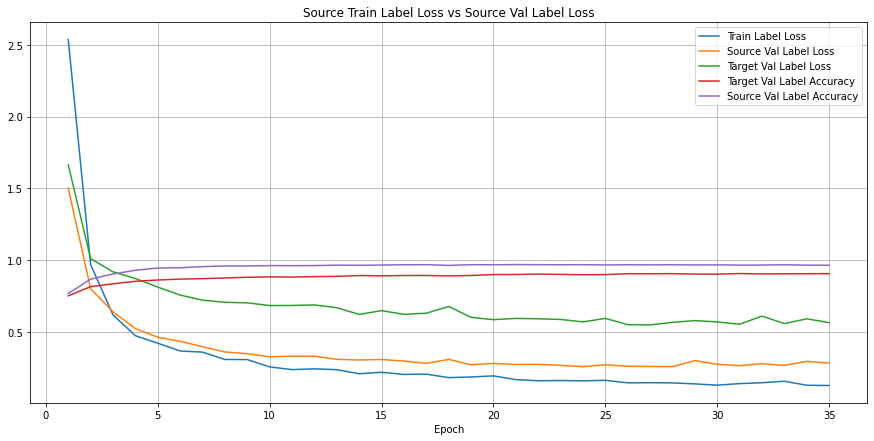

In [16]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

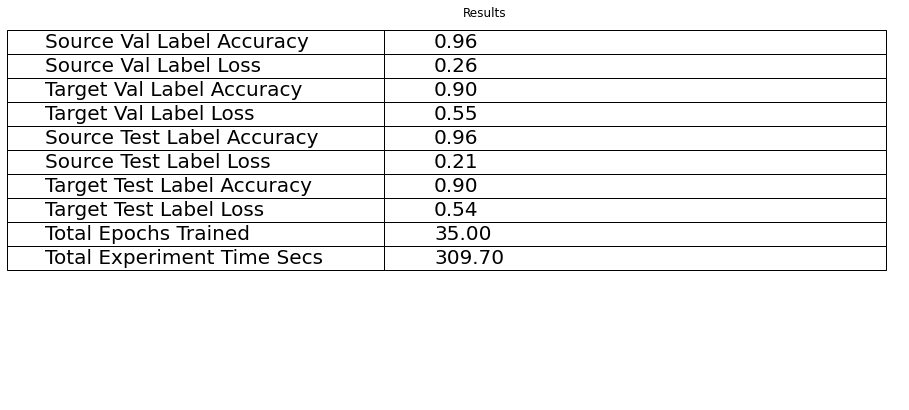

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

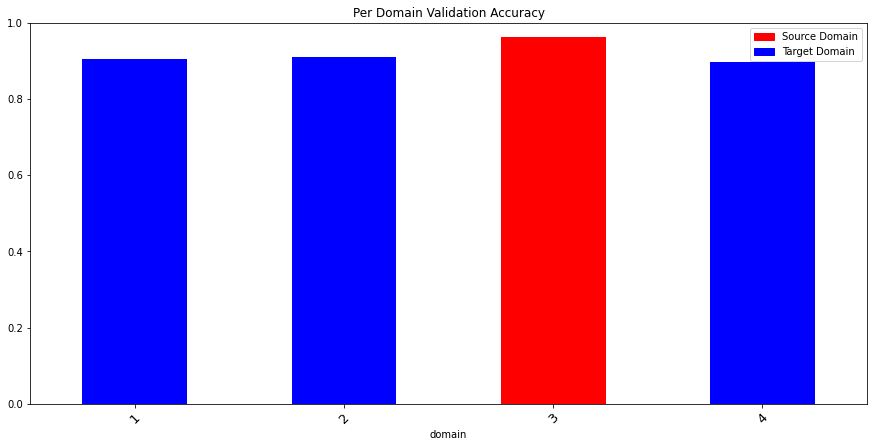

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9602564102564103 Target Test Label Accuracy: 0.9044871794871795
Source Val Label Accuracy: 0.9634615384615385 Target Val Label Accuracy: 0.9049145299145299


In [20]:
json.dumps(experiment)

'{"experiment_name": "tuned_1v2:wisig", "parameters": {"experiment_name": "tuned_1v2:wisig", "device": "cuda", "lr": 0.0001, "labels_source": ["1-10", "1-12", "1-14", "1-16", "1-18", "1-19", "1-8", "10-11", "10-17", "10-4", "10-7", "11-1", "11-10", "11-19", "11-20", "11-4", "11-7", "12-19", "12-20", "12-7", "13-14", "13-18", "13-19", "13-20", "13-3", "13-7", "14-10", "14-11", "14-12", "14-13", "14-14", "14-19", "14-20", "14-7", "14-8", "14-9", "15-1", "15-19", "15-6", "16-1", "16-16", "16-19", "16-20", "17-10", "17-11", "18-1", "18-10", "18-11", "18-12", "18-13", "18-14", "18-15", "18-16", "18-17", "18-19", "18-2", "18-20", "18-4", "18-5", "18-7", "18-8", "18-9", "19-1", "19-10", "19-11", "19-12", "19-13", "19-14", "19-15", "19-19", "19-2", "19-20", "19-3", "19-4", "19-6", "19-7", "19-8", "19-9", "2-1", "2-13", "2-15", "2-3", "2-4", "2-5", "2-6", "2-7", "2-8", "20-1", "20-12", "20-14", "20-15", "20-16", "20-18", "20-19", "20-20", "20-3", "20-4", "20-5", "20-7", "20-8", "3-1", "3-13", "